#Ankush Dey
#Roll :- MDS202108

In [ ]:
import numpy as np
import pandas as pd
import os
import math
import re
import time
import json
import random
import gc
import matplotlib.pyplot as plt
from itertools import islice
from tqdm.notebook import tqdm_notebook
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import h5py
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import pickle
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
lemmatizer = WordNetLemmatizer()
drive_directory = "/content/drive/MyDrive/"

In [ ]:
with open("/content/drive/MyDrive/inital_corpus.txt", 'r') as f:
    text = f.readlines()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocessing(data):
    data = data.lower()
    
    #removing stopwords
    STOPWORDS = set(stopwords.words('english'))
    text_1 = " ".join([word for word in data.split() if word not in STOPWORDS])
    
    #Removing Email 
    text_2 = re.sub(r"\S*@\S*\s?",'', text_1)
    
    #Removing Punctuation
    text_3 = re.sub(r'[^\w\s]', '', text_2)

    #Removing URLs
    text_4 = re.sub(r'^https?:\/\/.*[\r\n]*', '',text_3)

    #Removing dates
    text_5 = re.sub(r'^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', '', text_4)

    #Removing non-alphanumeric characters
    text_6 = re.sub(r'\W+', ' ', text_5)

    #Removing numbers
    text_7 = re.sub(r'[0-9]+', '', text_6)

    #Lemmatization of the words
    wordnet_lemmatizer = WordNetLemmatizer()
    text_8 = " ".join([wordnet_lemmatizer.lemmatize(word,pos='v') for word in text_7.split(" ")])

    return text_8

In [ ]:
with open(drive_directory+'test_corpus.txt', 'w') as f:
    for words in tqdm_notebook(range(len(text))):
        if words != '':
            #print(final_pad_str_text[words])
            f.write("%s\n" % preprocessing(text[words]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
with open("/content/drive/MyDrive/test_corpus.txt", 'r') as f:
    text1 = f.readlines()

In [ ]:
#creating vocabulary
count={}
for i in tqdm_notebook((range(len(text1)))):
    for word in text1[i].split(' '):
        if word not in count.keys():
            count[word]=1
        else:
            count[word]+=1

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
#taking only the keys with frequency more than 20 
key = list(count.keys())
for i in key:
    if count[i]<20:
        del(count[i])
del(count[''])        

In [ ]:
#Taking only 14000 most frequent words
d = dict(sorted(count.items(),key= lambda x:x[1],reverse=True))
l1 = list(d.keys())[:14000]


In [ ]:
with open(drive_directory+'vocab', 'wb') as f: 
    pickle.dump(l1,f) 
    f.close()

In [ ]:
with open("/content/drive/MyDrive/vocab",'rb') as f:
    vocab = pickle.load(f)

Here we are creating two matrices, in one we are  creating a matrix by looking a sentence from left to right and then right to left. Then we are horizonatally concatenating it. This is the final HAL matrix.

In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=10):
    word2Ind = {}
    word2Ind={word:end for end, word in enumerate(vocab)}
    M=np.zeros((len(vocab),len(vocab)),np.float32)
    M1=np.zeros((len(vocab),len(vocab)),np.float32)
    for i in tqdm_notebook(range(len(corpus))):
        token=corpus[i].split(" ")
        ngrams11=list(ngrams(token,11))
        ramp = [0, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
        for index, grams in enumerate(ngrams11):
            for idx, gram in enumerate(grams):
                try:
                    M[word2Ind[grams[0]],word2Ind[grams[idx]]] += ramp[idx]
                except:
                    continue        
            reversed_grams = grams[::-1]
            for idx, gram in enumerate(reversed_grams):
                try:
                    M1[word2Ind[reversed_grams[0]],word2Ind[reversed_grams[idx]]] += ramp[idx]
                except:
                    continue                 
    return M, M1

    

In [ ]:
hal_matrix_l2r,hal_matrix_r2l = compute_co_occurrence_matrix(text1, window_size=10)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
final_hal_matrix = np.concatenate((hal_matrix_r2l,hal_matrix_l2r), axis=1) 

In [ ]:
h5f = h5py.File('/content/drive/MyDrive/matrix', 'w')
h5f.create_dataset('dataset_1', data=final_hal_matrix,compression='gzip')
h5f.close()

In [ ]:
h5f = h5py.File('/content/drive/MyDrive/matrix','r')
mat = h5f['dataset_1'][:]
h5f.close()

In [ ]:
#normalizing the matrix by row
normed_matrix = normalize(mat, axis=1, norm='l1')

We using singular value decomposition technique to reduce the dimension from 14000 to 200, this M_reduced matrix will be used to find the nearest words.

In [ ]:
%%time
svd = TruncatedSVD(n_components = 200, n_iter=10)
M_reduced = svd.fit_transform(normed_matrix)
M_reduced

CPU times: user 1min 52s, sys: 7.79 s, total: 2min
Wall time: 1min 22s


array([[ 5.9035398e-02, -9.5827756e-03,  1.9828374e-03, ...,
        -1.0045699e-04,  4.2285645e-04, -6.5925771e-05],
       [ 3.9517339e-02, -7.3136468e-03,  5.9162616e-03, ...,
         4.2912790e-05,  2.0109942e-04,  1.0259885e-04],
       [ 4.3076146e-02, -7.5079026e-03,  3.1624460e-03, ...,
         3.7102334e-05, -4.7882256e-04, -4.9604283e-04],
       ...,
       [ 1.3753392e-01, -2.0324938e-02,  2.7959876e-02, ...,
         2.3212645e-03, -1.0143866e-04, -2.4537360e-03],
       [ 5.2723326e-02, -7.8926980e-03, -1.7182339e-02, ...,
         1.8263996e-02,  2.9161099e-02,  3.1697582e-02],
       [ 1.3034078e-01, -2.0541128e-02, -4.0887184e-03, ...,
         2.1338711e-02,  2.9129786e-02,  2.8651133e-02]], dtype=float32)

Here we are finding words which are closest to the given word, for this we are using euclidean distance.

In [ ]:
def nearest_word(w):
    word2Ind={word:end for end, word in enumerate(vocab)}
    similar_word={}
    src_index = word2Ind[w]
    vec_1 = M_reduced[src_index,:]
    for i in tqdm_notebook(word2Ind.keys()):
        target_index = word2Ind[i]
        vec_2 = M_reduced[target_index,:]
        euclidean_distance = np.linalg.norm(vec_1 - vec_2)
        similar_word[i] = euclidean_distance   
    del(similar_word[w])
    return dict(sorted(similar_word.items(),key= lambda x:x[1], reverse = False))

In [ ]:
def plot_embeddings(M_reduced, words):
    word2Ind={word:end for end, word in enumerate(vocab)}
    M_reduced_2 =  TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(M_reduced)
    x_coords = M_reduced_2[:, 0]
    y_coords = M_reduced_2[:, 1]
    plt.figure(figsize=(6,6))
    for word in words:
        idx = word2Ind[word]
        embedding = M_reduced_2[idx]
        x = embedding[0]
        y = embedding[1]
        plt.scatter(x, y, marker='o', color='red')
        plt.text(x, y, word, fontsize = 14)
    return plt.show()

  0%|          | 0/14000 [00:00<?, ?it/s]

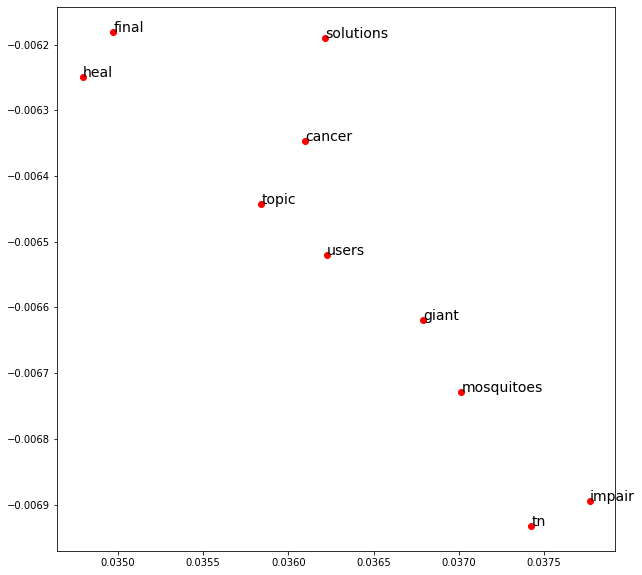

{'solutions': 0.0063843764,
 'users': 0.0066532185,
 'topic': 0.006669798,
 'final': 0.006693528,
 'giant': 0.006911651,
 'tn': 0.0070603853,
 'impair': 0.007272049,
 'cancer': 0.007272612,
 'heal': 0.0073393667,
 'mosquitoes': 0.0074041565}

In [ ]:
top_10 = dict(islice(nearest_word('virus').items(),10))
plot_embeddings(M_reduced, top_10)
top_10

  0%|          | 0/14000 [00:00<?, ?it/s]

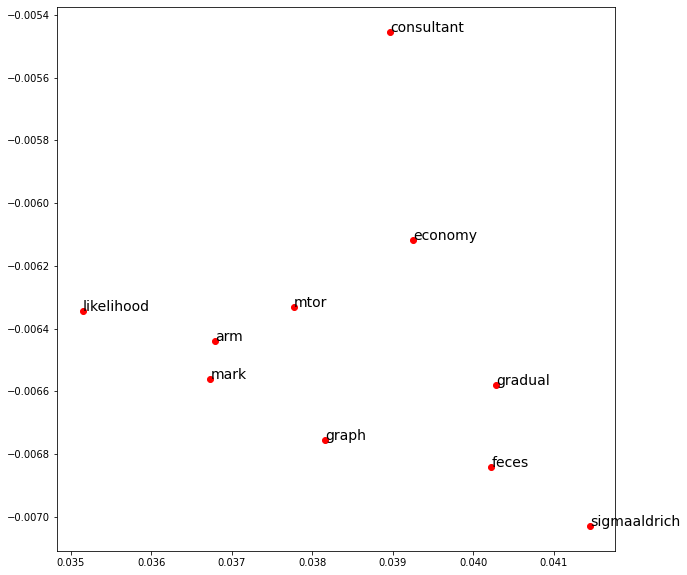

{'mtor': 0.0071337963,
 'mark': 0.008206413,
 'economy': 0.008230443,
 'feces': 0.00826705,
 'arm': 0.008277911,
 'consultant': 0.008284643,
 'gradual': 0.00829143,
 'sigmaaldrich': 0.008321103,
 'likelihood': 0.008332268,
 'graph': 0.00833255}

In [ ]:
top_10 = dict(islice(nearest_word('examination').items(),10))
plot_embeddings(M_reduced, top_10)
top_10

  0%|          | 0/14000 [00:00<?, ?it/s]

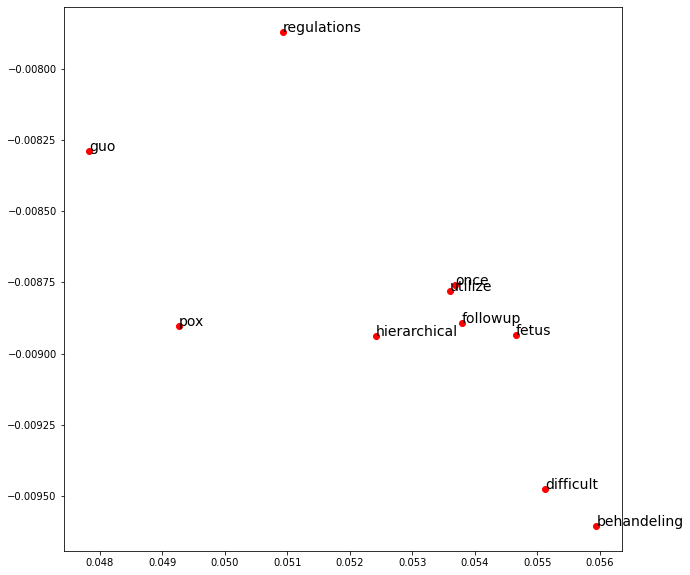

{'fetus': 0.008390008,
 'regulations': 0.012699405,
 'once': 0.012709265,
 'behandeling': 0.015526516,
 'hierarchical': 0.016776802,
 'utilize': 0.01733284,
 'difficult': 0.018258838,
 'pox': 0.01876033,
 'followup': 0.018900491,
 'guo': 0.019800419}

In [ ]:
top_10 = dict(islice(nearest_word('coronaviruses').items(),10))
plot_embeddings(M_reduced, top_10)
top_10

  0%|          | 0/14000 [00:00<?, ?it/s]

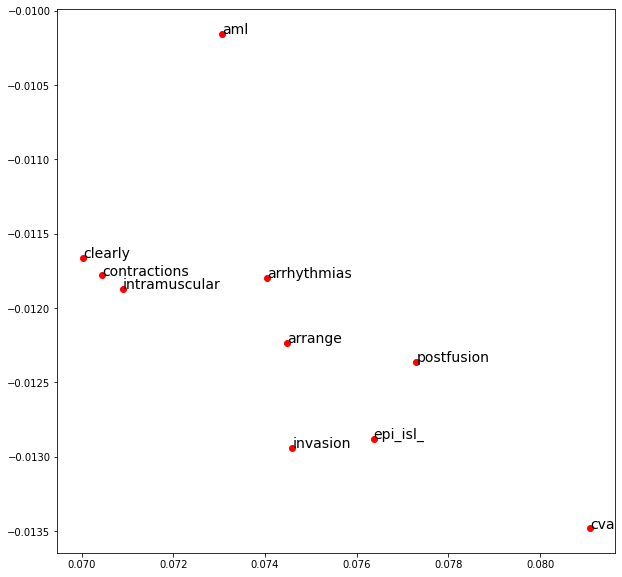

{'arrange': 0.009355364,
 'contractions': 0.013188342,
 'epi_isl_': 0.013403663,
 'invasion': 0.013861325,
 'cva': 0.013879733,
 'clearly': 0.013938078,
 'intramuscular': 0.014104339,
 'arrhythmias': 0.014106476,
 'aml': 0.0142990695,
 'postfusion': 0.014309446}

In [ ]:
top_10 = dict(islice(nearest_word('pathogen').items(),10))
plot_embeddings(M_reduced, top_10)
top_10